In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR, METRIC_DIFF_MOD_AGNOSTIC_MOD_SPECIFIC, METRIC_CROSS_DECODING
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, RIDGE_DECODER_OUT_DIR, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS, TRAINING_MODES, CAPTION, IMAGE
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, ACC_CROSS_MEAN, PALETTE_BLACK_ONLY, METRICS_ERROR_ANALYSIS, get_data_default_feats, METRICS_BASE, calc_model_feat_order, FEATS_MULTIMODAL, DEFAULT_FEAT_OPTIONS
%load_ext autoreload
%autoreload 2

In [2]:
MODELS = [
    "random-imagebind", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
    "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
    "visualbert", "bridgetower", "vilt", "siglip", "paligemma2", "clip", "flava", "blip2", "imagebind"
]

for model in MODELS:
    print(model, end=" ")

random-imagebind vit-b-16 vit-l-16 resnet-18 resnet-50 resnet-152 dino-base dino-large dino-giant bert-base-uncased bert-large-uncased llama2-7b llama2-13b mistral-7b mixtral-8x7b gpt2-small gpt2-medium gpt2-large gpt2-xl visualbert bridgetower vilt siglip paligemma2 clip flava blip2 imagebind 

In [3]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)
# all_data = load_results_data(MODELS, recompute_acc_scores=True, standardize_predictions=False)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data_vol = all_data[all_data.surface == False].copy()

all_data = all_data[all_data.surface == True].copy()

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
model_feat_multimodal_single_modaltity_features = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]



100%|██████████| 1321/1321 [02:07<00:00, 10.36it/s]


## Feature comparison for multimodal models

In [4]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == MODALITY_AGNOSTIC)]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
    # grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features", "subject"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()

    # grouped = grouped[grouped.model.isin(multimodal_models)]
    display(grouped)

# print(grouped.to_markdown())

# grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
# print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,count,pairwise_acc,pairwise_acc_stddev
0,bert-base-uncased,lang,n_a,lang_features_mean,6,0.826398,0.027903
1,bert-large-uncased,lang,n_a,lang_features_mean,6,0.802864,0.020875
2,blip2,avg,vision_features_cls,lang_features_cls,6,0.859075,0.025940
3,bridgetower,fused_cls,n_a,n_a,6,0.823965,0.033818
4,clip,avg,vision_features_cls,lang_features_cls,6,0.847550,0.027533
5,dino-base,vision,vision_features_mean,n_a,6,0.823344,0.025359
6,dino-giant,vision,vision_features_mean,n_a,6,0.830090,0.025914
7,dino-large,vision,vision_features_mean,n_a,6,0.824189,0.022599
8,flava,avg,vision_features_cls,lang_features_cls,6,0.852864,0.031745
9,gpt2-large,lang,n_a,lang_features_mean,6,0.853123,0.023475


In [5]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = get_default_vision_features(model)
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
# feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean"}
# feat_order = ["vision", "lang", "fused_cls", "fused_mean", "matched", "avg", "concat"]
# feat_order_long = [feat_legend[feat] for feat in feat_order]

# data_to_plot = data_default_vision_feats.copy()

# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

# model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

# metrics_order = [ACC_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Modality-agnostic decoding vs. modality-specific decoding

### Model features comparison

In [6]:
data_default_feats = get_data_default_feats(all_data)

In [7]:
model_order = ['random-imagebind']
model_feat_order = ['random-imagebind_avg']
for features in DEFAULT_FEAT_OPTIONS:
    print('\nmodel feat type: ', features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    # scores = dp.groupby("model").value.mean().sort_values()
    scores = dp.groupby("model_feat").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend([mf.split('_')[0] for mf in scores.index.values])
        model_feat_order.extend(scores.index.values)
    
model_order
# model_feat_order


model feat type:  vision
model_feat
resnet-152_vision    0.766580
vit-b-16_vision      0.771325
vit-l-16_vision      0.801311
resnet-18_vision     0.805210
resnet-50_vision     0.810093
dino-base_vision     0.823344
dino-large_vision    0.824189
dino-giant_vision    0.830090
Name: value, dtype: float64

model feat type:  lang
model_feat
bert-large-uncased_lang    0.802864
bert-base-uncased_lang     0.826398
llama2-7b_lang             0.830349
mixtral-8x7b_lang          0.832833
mistral-7b_lang            0.834541
llama2-13b_lang            0.841184
gpt2-small_lang            0.841615
gpt2-medium_lang           0.848344
gpt2-xl_lang               0.852692
gpt2-large_lang            0.853123
Name: value, dtype: float64

model feat type:  fused_mean
model_feat
visualbert_fused_mean    0.750656
vilt_fused_mean          0.846273
Name: value, dtype: float64

model feat type:  fused_cls
model_feat
bridgetower_fused_cls    0.823965
Name: value, dtype: float64

model feat type:  avg
model_feat

['random-imagebind',
 'resnet-152',
 'vit-b-16',
 'vit-l-16',
 'resnet-18',
 'resnet-50',
 'dino-base',
 'dino-large',
 'dino-giant',
 'bert-large-uncased',
 'bert-base-uncased',
 'llama2-7b',
 'mixtral-8x7b',
 'mistral-7b',
 'llama2-13b',
 'gpt2-small',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'visualbert',
 'vilt',
 'bridgetower',
 'random-imagebind',
 'clip',
 'paligemma2',
 'flava',
 'siglip',
 'blip2',
 'imagebind']

In [8]:
cross_decoding_scores = dict()
for model in data_default_feats.model.unique():
    filtered = all_data[all_data.model == model]
    cross_images = filtered[(filtered.metric == ACC_IMAGES) & (filtered.training_mode == MODALITY_SPECIFIC_CAPTIONS)].value.mean()
    cross_captions = filtered[(filtered.metric == ACC_CAPTIONS) & (filtered.training_mode == MODALITY_SPECIFIC_IMAGES)].value.mean()

    cross_decoding_scores[model] = np.mean((cross_images, cross_captions))

print({k: v for k, v in sorted(cross_decoding_scores.items(), key=lambda item: item[1])})


{'random-imagebind': 0.5833850931677018, 'resnet-152': 0.6574189095928227, 'vit-b-16': 0.6677536231884058, 'visualbert': 0.6680641821946169, 'bert-large-uncased': 0.6879227053140096, 'resnet-18': 0.6991028295376122, 'resnet-50': 0.7000345065562457, 'bridgetower': 0.7004830917874396, 'vit-l-16': 0.7088509316770186, 'llama2-7b': 0.7165631469979297, 'mixtral-8x7b': 0.7166494133885438, 'mistral-7b': 0.7169254658385094, 'dino-base': 0.7174430641821946, 'dino-large': 0.7175810904071774, 'dino-giant': 0.7188233264320221, 'bert-base-uncased': 0.7194271911663216, 'llama2-13b': 0.7271394064872325, 'clip': 0.7307625948930296, 'gpt2-small': 0.7317977915804004, 'flava': 0.7345583160800553, 'gpt2-medium': 0.7355417529330572, 'gpt2-large': 0.7368012422360247, 'gpt2-xl': 0.7370772946859903, 'blip2': 0.738500690131125, 'vilt': 0.7402691511387163, 'siglip': 0.7407694962042788, 'paligemma2': 0.7413302277432712, 'imagebind': 0.7451844868382136}


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


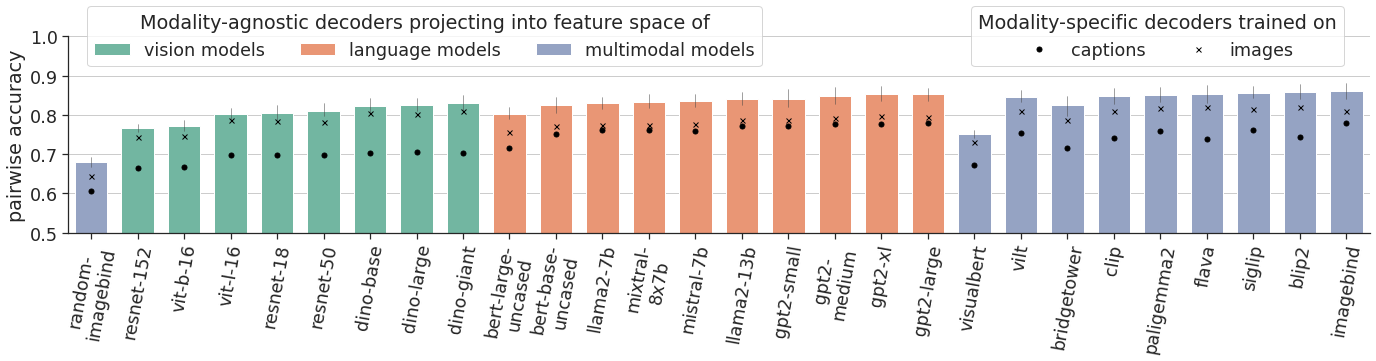

In [9]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.98,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


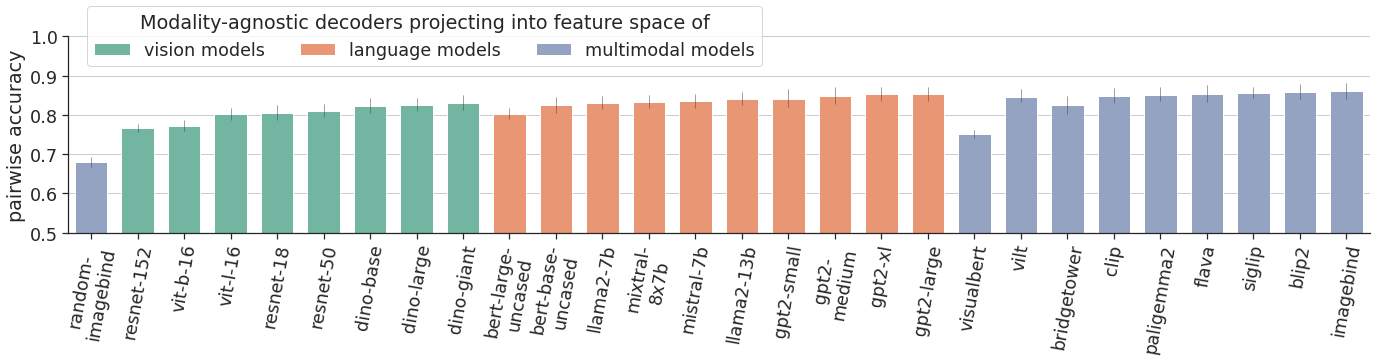

In [10]:
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.98,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False, plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_no_mod_specific.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


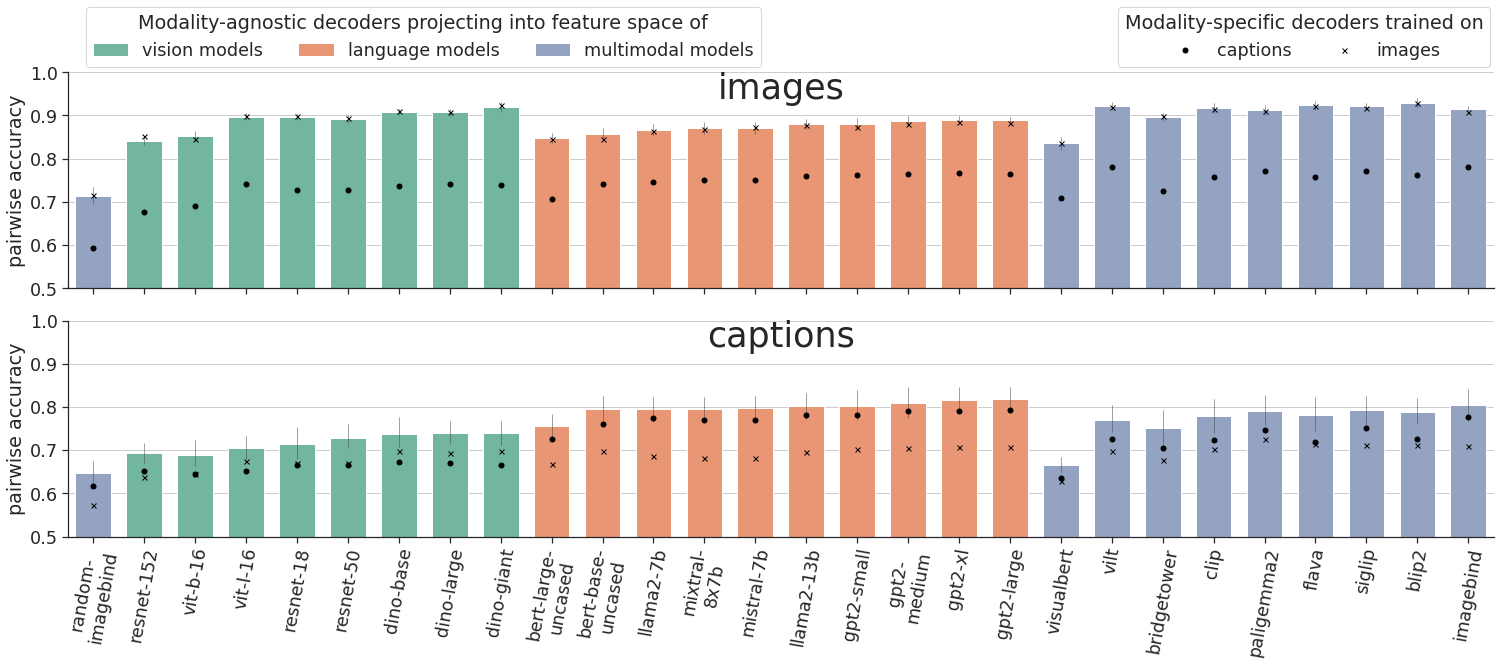

In [11]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGES, ACC_CAPTIONS]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


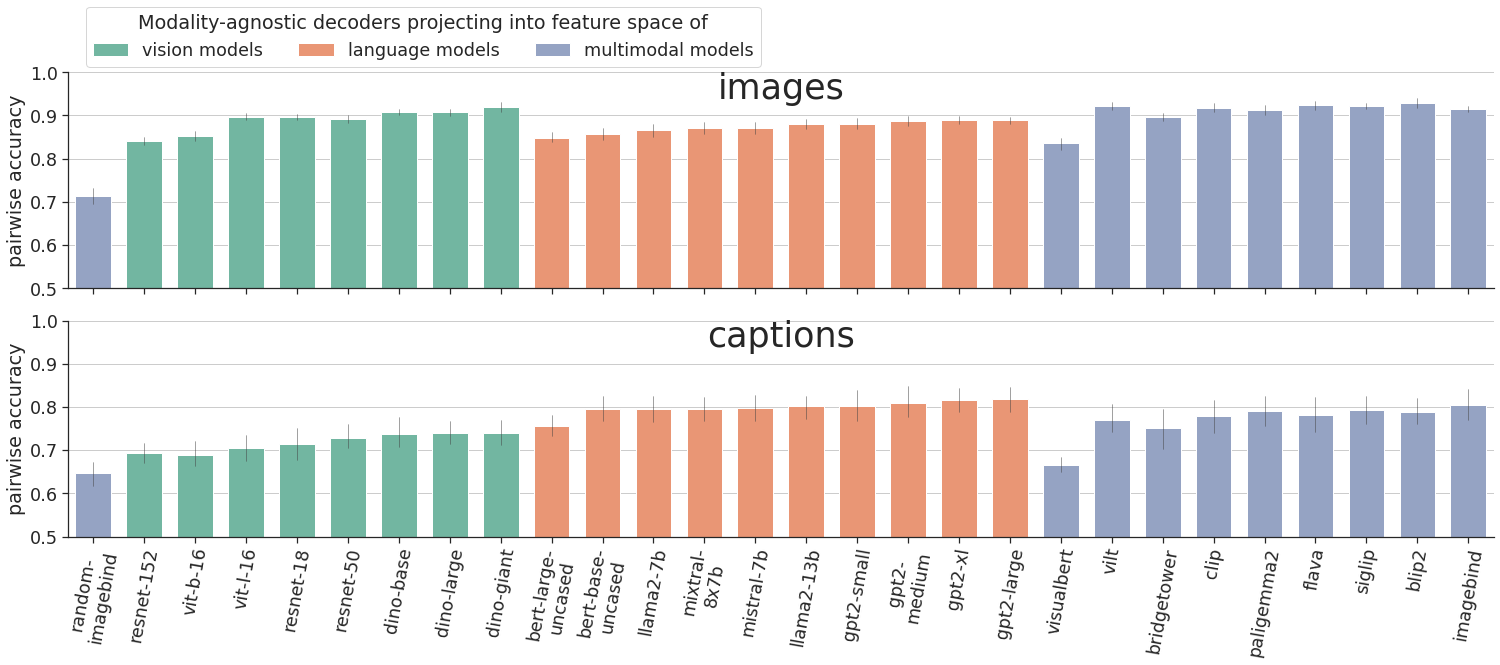

In [12]:
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False, plot_modality_specific=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality_no_mod_specific.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [74]:
from scipy.stats import ttest_ind
data_ttest = data_default_feats.copy()
for metric in [ACC_IMAGES, ACC_CAPTIONS, ACC_IMAGERY_WHOLE_TEST]:
    print(metric)
    data_filtered = data_ttest[data_ttest.metric == metric]
    data_mod_agno = data_filtered[data_filtered.training_mode == "agnostic"]
    # data_mod_agno = data_mod_agno[data_mod_agno.model == "imagebind"]
    assert len(data_mod_agno) == len(SUBJECTS) * len(data_mod_agno.model.unique())

    data_mod_spec = data_filtered[data_filtered.training_mode == "images"] if metric == ACC_IMAGES else data_filtered[data_filtered.training_mode == "captions"]
    if metric == ACC_IMAGERY_WHOLE_TEST:
        data_mod_spec = data_filtered[data_filtered.training_mode != "agnostic"]
        assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique()) * 2
    else:
        assert len(data_mod_spec) == len(SUBJECTS) * len(data_mod_spec.model.unique())

    #TODO take model and subject into account?
    print('mod agno: ', data_mod_agno.value.mean())
    print('mod spec: ', data_mod_spec.value.mean())
    print(ttest_ind(data_mod_agno.value.values, data_mod_spec.value.values))
    print('\n')

pairwise_acc_images
mod agno:  0.8837350882381939
mod spec:  0.8820837030464359
TtestResult(statistic=0.3354637622453085, pvalue=0.7374858857301283, df=334.0)


pairwise_acc_captions
mod agno:  0.7609028393966282
mod spec:  0.7196551809129449
TtestResult(statistic=5.530177083635766, pvalue=6.463421692074505e-08, df=334.0)


pairwise_acc_imagery_whole_test_set
mod agno:  0.7092695059244355
mod spec:  0.6839858596020568
TtestResult(statistic=2.0187892440514137, pvalue=0.044040268754377054, df=502.0)




/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


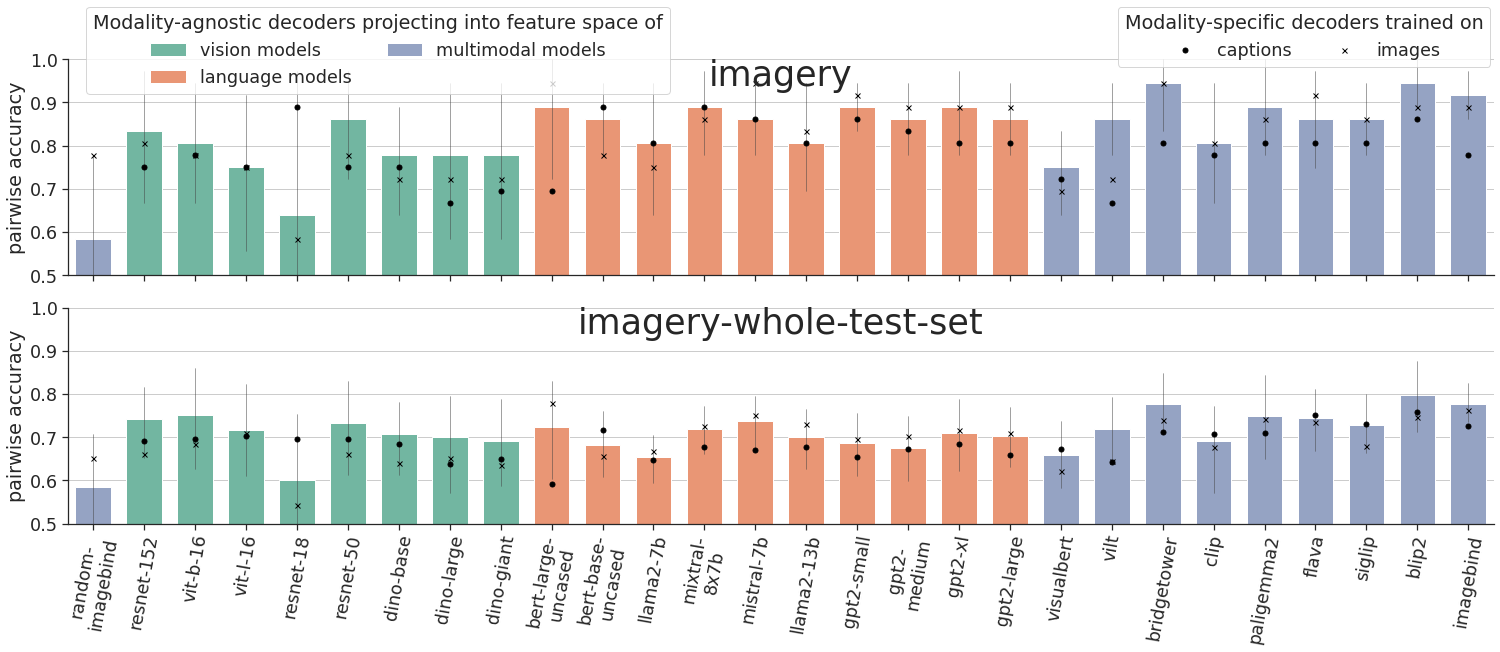

In [11]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.03), legend_2_bbox=(0.99,1.03), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


# Imagery decoding with mask

In [143]:
MODEL = "imagebind"
# all_data_imagebind_unstandardized = load_results_data([MODEL], recompute_acc_scores=True, standardize_predictions=False)
all_data_imagebind = load_results_data([MODEL], recompute_acc_scores=False)

100%|██████████| 1429/1429 [00:27<00:00, 52.75it/s]


acc whole brain: 0.78
acc masked: 0.70
TtestResult(statistic=0.8639750036368619, pvalue=0.4078472476971833, df=10.0)


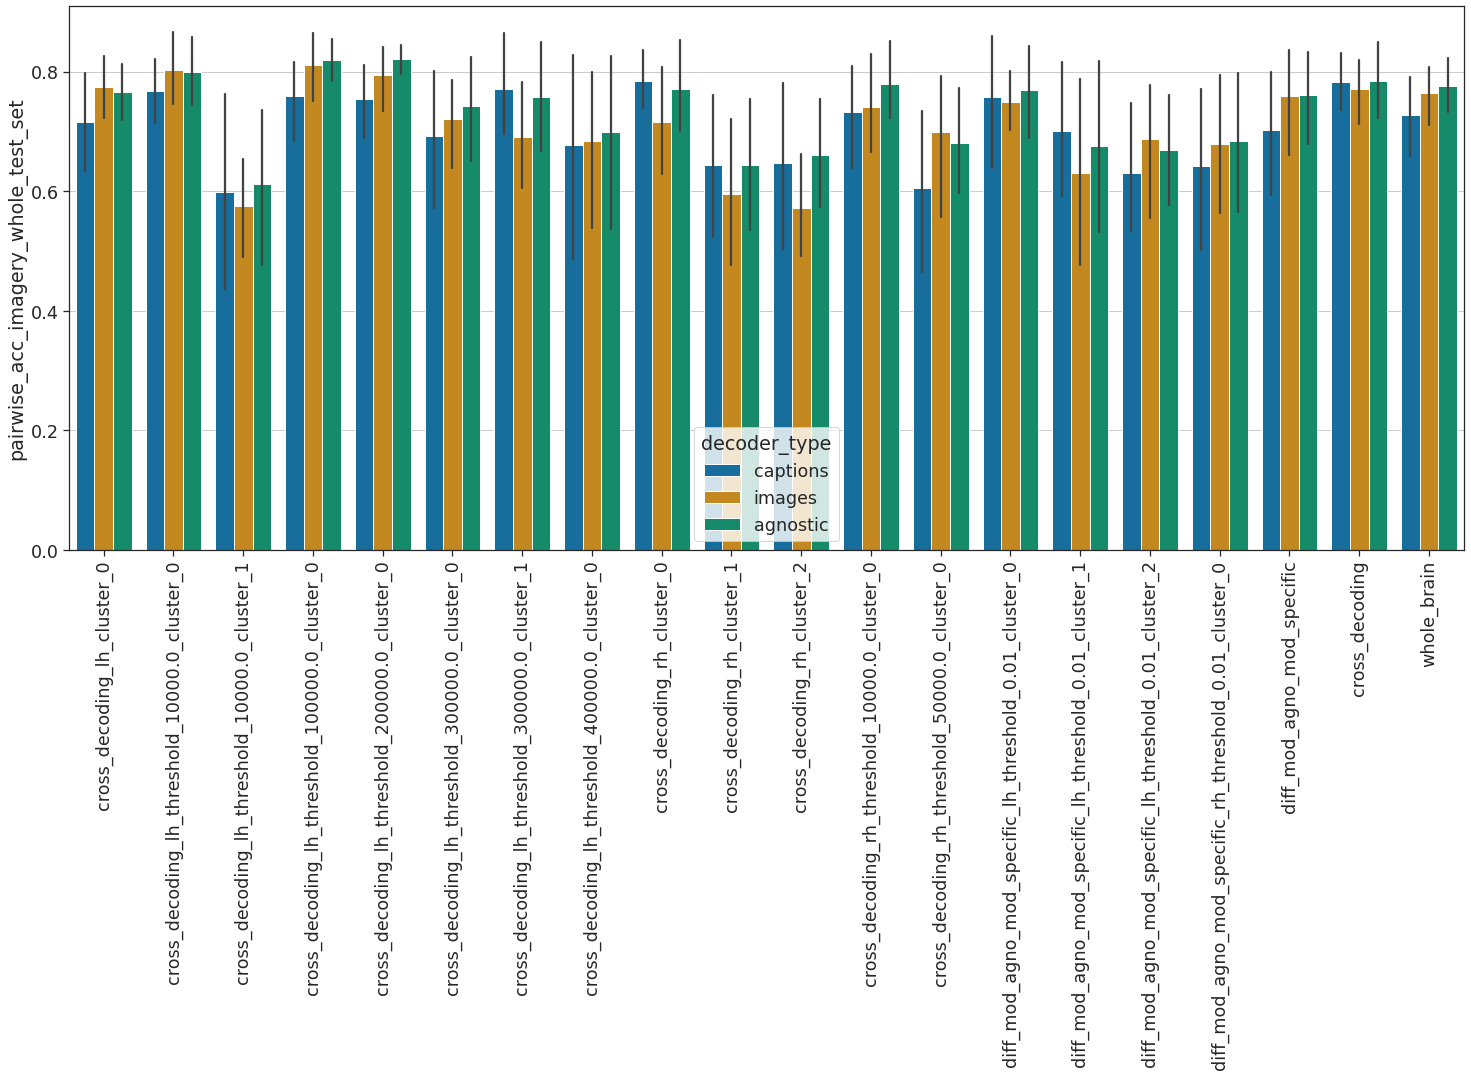

In [147]:

filtered = get_data_default_feats(all_data_imagebind)
# filtered = filtered[filtered.training_mode == "agnostic"]
filtered = filtered[filtered.surface == True]
# METRIC = ACC_IMAGERY
METRIC = ACC_IMAGERY_WHOLE_TEST
# METRIC = ACC_MEAN
# METRIC = ACC_IMAGES



filtered = filtered[filtered.metric == METRIC]

def shorten_mask_name(name):
    if name == "whole_brain":
        return name
    return os.path.basename(name).replace('mask_', '')

    
filtered["mask"] = filtered["mask"].apply(shorten_mask_name)
# print(filtered["mask"].unique())

# MASK_NAME = 'cross_encoding'
MASK_NAME = 'cross_decoding_lh_threshold_400000.0_cluster_0'
# MASK_NAME = 'cross_decoding_rh_threshold_10000.0_cluster_0'
# MASK_NAME = 'mask_cross_decoding'
# MASK_NAME = 'diff_mod_agno_mod_specific'


# filtered = filtered[filtered["mask"].isin(['whole_brain', MASK_NAME])]
filtered = filtered[~filtered["mask"].isin(['cross_encoding'])]


# filtered['mask'] = filtered['mask'].replace({MASK_NAME: True, 'whole_brain': False}).astype(bool)
# filtered['mask'] = filtered['mask'].replace({MASK_NAME: 'mod_agnostic_mask'})

filtered['decoder_type'] = filtered['training_mode']
ORDER = None# ['whole_brain', MASK_NAME]
HUE_ORDER = ['captions', 'images', 'agnostic']

plt.figure(figsize=(25, 10))
# plt.title(METRIC)
sns.barplot(data=filtered, x="mask", y="value", hue="decoder_type", order=ORDER, hue_order=HUE_ORDER, palette=sns.color_palette("colorblind", 3))
plt.xlabel('')
plt.ylabel(METRIC)
plt.xticks(rotation=90)
# _ = plt.xticks(rotation=90)
plt.savefig(os.path.join(RESULTS_DIR, f"masked_decoding_{METRIC}.png"), dpi=300, bbox_inches='tight', pad_inches=0)

pd.set_option('display.max_rows', 500)

grouped = filtered.groupby(["mask", 'decoder_type']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index()
grouped['num_voxels'] = grouped['num_voxels'].astype(int)
# display(grouped)

accs_agnostic = filtered[filtered.decoder_type=='agnostic']
accs_whole_brain = accs_agnostic[accs_agnostic['mask']=='whole_brain']
accs_masked = accs_agnostic[accs_agnostic['mask']==MASK_NAME]

assert len(accs_whole_brain) == len(SUBJECTS)
assert len(accs_masked) == len(SUBJECTS) #TODO

# import statsmodels.formula.api as smf
# formula = 'value ~ mask * C(decoder_type)'
# model = smf.glm(formula=formula, data=filtered)#, family=family)
# result = model.fit()
# print(result.summary())

print(f'acc whole brain: {accs_whole_brain.value.mean():.2f}')
print(f'acc masked: {accs_masked.value.mean():.2f}')
print(ttest_ind(accs_whole_brain.value.values, accs_masked.value.values))

# display(filtered.groupby(["mask"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
# display(filtered.groupby(["mask", 'training_mode', 'subject']).agg(count=('value', 'size'), num_voxels=('num_voxels', 'mean'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())
# display(filtered.groupby(["mask", 'subject']).agg(count=('value', 'size'), pairwise_acc=('value', 'mean'), pairwise_acc_stddev=('value', 'std')).reset_index())




## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, order=model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == MODALITY_AGNOSTIC]


    # assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6
    for mode in TRAINING_MODES:
        data_mode = data[data.training_mode == mode]
        for x_variable_value in order:
            length = len(data_mode[(data_mode["model_feat"] == x_variable_value) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            if hue_variable != "features":
                expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {x_variable_value} {mode}"
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot, MODELS)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# Cross-modal decoding

In [ ]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_CROSS_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"cross_modal_decoding_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# 

# Error analysis

In [ ]:
models = ['imagebind']

data = load_results_data(models, metrics=METRICS_ERROR_ANALYSIS)

# metric = ACC_IMAGES

all_data = data[data.model.isin(MODELS)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data = all_data[all_data.surface == False]

data_default_feats_err_analysis = get_data_default_feats(all_data)

In [ ]:
def all_pairwise_accuracy_scores(latents, predictions, stim_types=None, metric="cosine", standardize=True):
    results = dict()
    results['comp_mats'] = dict()
    
    for modality, acc_metric_name in zip([CAPTION, IMAGE], [ACC_CAPTIONS, ACC_IMAGES]):
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if standardize:
            preds_mod = StandardScaler().fit_transform(preds_mod)

        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat

        score = dist_mat_to_pairwise_acc(dist_mat)

        results[acc_metric_name] = score
        results['comp_mats'][acc_metric_name] = (~comp_mat).astype(int)

    if standardize:
        predictions = StandardScaler().fit_transform(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]
        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min
        score = dist_mat_to_pairwise_acc(dist_mat_min)
        # scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.append(score)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = score
        results['comp_mats'][f"pairwise_acc_mod_agnostic_{modality}s"] = (~comp_mat).astype(int)

    results[ACC_MODALITY_AGNOSTIC] = np.mean(mod_agnostic_accs)

    return results

metric = ACC_IMAGES #TODO which metric?

all_subj_mats = []
for subject in SUBJECTS:
    df = data_default_feats_err_analysis.copy()
    df_subj = df[(df.training_mode == MODALITY_AGNOSTIC) & (df.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
    
    results = all_pairwise_accuracy_scores(latents, predictions, stimulus_types)
    print(results[ACC_IMAGES])    
    mat = results['comp_mats'][metric]
    all_subj_mats.append(mat)

mat = np.sum(all_subj_mats, axis=0)
mat = mat - np.diag(np.diag(mat))

df_err = pd.DataFrame(mat, index=stimulus_ids[:70], columns=stimulus_ids[:70])

In [ ]:
# df_err = df_err.map(lambda x: 0 if x < 3 else x)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_err)

In [ ]:
stimuli_info = np.load(STIM_INFO_PATH, allow_pickle=True)
img_paths = {id: os.path.join(COCO_IMAGES_DIR, path) for id, path, caption in stimuli_info}
captions_dict = {id: caption for id, path, caption in stimuli_info}

from PIL import Image

def display_stimuli(coco_ids):
    imgs = [Image.open(img_paths[img_id]).convert('RGB') for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    # print(min_height)
    captions = [captions_dict[coco_id] for coco_id in coco_ids]
    for cap in captions:
        print(cap)
    display(img)
    
# display_imgs([183210, 79642])


In [ ]:
for id1, row in df_err.iterrows():
    confusions = []
    for id2, count in row.items():
        if count > 5:
            confusions.append(id2)
    if len(confusions) > 0:
        print(f'common confusions involving id {id1}:\n')
        confusions = [id1] + confusions
        display_stimuli(confusions)
        print('\n\n')
